# What has Changed:
1. When calling the model we should pass the full size of the image, so that the bias is initialized to that size. When we want to use different size images we just pass the resized image through the model and everything should be done in the model. 
2. The resize functions are now working. Note: Not all images are the same size so in every epoch we have to resize all the images to the correct size, and when resizing remember sizes must be divisible by 32 to avoid rounding which causes a tensor mismatch when concatinating

TODO: Currently I am only working on the segmentation task. So there are still things to adjust in the detection task

3. For the detection task I think we misunderstood the paper, the papers mentions that they use a similair approach to sweatyNet so from what I understood is that the labels and outputs are not bounding boxes, but they are gaussian blurs, so for the training data we convert the center of the bounding box of the ball to a gaussian blob, and then the result of the model is a heatmap, and then they used some algorthim to detect the peaks in the heatmap, and these peaks are the models detection. (As far as I understood, but I will double check with hafez) 
4. Hafez told me that the output of the segmentation needs to be (B, 1, H, W), we should then visualize in RGB in whichever way we want. So I adjusted the labels of the segmentation dataset, and fixed the visualization methods to work with the default dataloader(also needed to adjust the mapping labels).
5. Apparently we cannot load images which are of different size in the same batch, so now we have to apply the resize transformation in the dataset, I tried to apply it on the dataloader, but coulden't find a way so I just add it to the dataset class.

# Imports

In [1]:
# Add module files on path
import sys
sys.path.append('./modules')

# Importing
import torch
import numpy as np
from model import Model
from torch.utils.data import DataLoader, random_split
from dataset import MyDecDataset, MySegDataset, MyDataLoader
from helpers import xml_to_csv,resize_seg,resize_det,reverse_normalize,total_variation_loss
from visualize import show_labeled_image, show_image_and_seg, show_image_and_probmap

torch.manual_seed(24)

# Datasets

## Detection Dataset

### TODOS:

- Transformations applied to train, val, and test.... Maybe we need to find a better way

In [2]:
# Convert XML files to CSV to create dataset
xml_to_csv('./Dataset/blob/**/*.xml', 'labels.csv')

Processed 8876 images


In [3]:
# Create custom dataset class
dataset_dt = MyDecDataset('labels.csv')

In [4]:
# Split dataset
train_size = int(0.7 * len(dataset_dt))
test_size = int(0.15 * len(dataset_dt))
validation_size = len(dataset_dt) - (train_size + test_size)

train_dt, validation_dt, test_dt = random_split(dataset_dt, [train_size, validation_size, test_size])

In [5]:
print("Size of detection test set", len(train_dt))
print("Size of detection training set:", len(test_dt))
print("Size of detection validation set:", len(validation_dt))

Size of detection test set 6209
Size of detection training set: 1330
Size of detection validation set: 1332


Shape:  torch.Size([3, 360, 540])
Shape:  torch.Size([1, 480, 640])


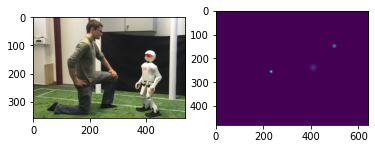

In [6]:
test_loader_dt = MyDataLoader(test_dt, batch_size=1, shuffle=True)
train_loader_dt = MyDataLoader(train_dt, batch_size=1, shuffle=True)
validation_loader_dt = MyDataLoader(validation_dt, batch_size=1, shuffle=True)

# Display first training image
for image, target in train_loader_dt:
    print("Shape: ", image[0].shape)
    print("Shape: ", target[0].shape)
    
    show_image_and_probmap(image[0], target[0])
    #show_labeled_image(image[0], target[0]["boxes"], target[0]["labels"])
    break

## Segmentation Dataset

In [7]:
# Create custom dataset
dataset_seg = MySegDataset('./Dataset/segmentation') # or define the w, and the h

In [8]:
print("Size of segmentation dataset ", len(dataset_seg))

Size of segmentation dataset  1192


In [9]:
# Split dataset
train_size = int(0.7 * len(dataset_seg))
test_size = int(0.15 * len(dataset_seg))
validation_size = len(dataset_seg) - (train_size + test_size)

train_seg, validation_seg, test_seg = random_split(dataset_seg, [train_size, validation_size, test_size])

In [10]:
print("Size of segmentation test set", len(test_seg))
print("Size of detection training set:", len(train_seg))
print("Size of detection validation set:", len(validation_seg))

Size of segmentation test set 178
Size of detection training set: 834
Size of detection validation set: 180


Image path:  ./Dataset/segmentation/dataset/image/opx_frame002265.jpg
Label:  ./Dataset/segmentation/dataset/target/opx_frame002265.png
Target Shape:  torch.Size([1, 480, 640])
Image Shape:  torch.Size([3, 480, 640])


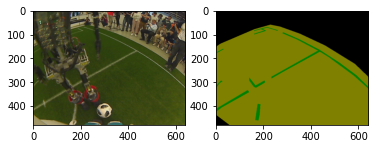

In [11]:
# Create dataloader for segmentation data
test_loader_seg = DataLoader(test_seg, batch_size=1, shuffle=True)
train_loader_seg =DataLoader(train_seg, batch_size=1, shuffle=True)
validation_loader_seg = DataLoader(validation_seg, batch_size=1, shuffle=True)

# Just as a sanity check display the test set
for image, target in train_loader_seg:
    print("Target Shape: ", target[0].shape)
    print("Image Shape: ", image[0].shape)
        
    show_image_and_seg(image[0],target[0])
    break

### Model

In [12]:
model = Model(640,480)
test_seg_data_loader = DataLoader(test_seg, batch_size=1, shuffle=True)
for _, (images, targets) in enumerate (test_seg_data_loader):
    print("Size of input",images[0].shape)
    print("Size of target",targets[0].shape)
    downsampled_target =  torch.nn.UpsamplingNearest2d(scale_factor=0.25)(targets)
    print("Size of target after downsampling",downsampled_target.shape)
    output = model(images,head="segmentation")
    print("Size of model ouput",output.shape)
    downsampled_target = torch.squeeze(downsampled_target,dim=1) # this is to change the input from (batch_size,1,H,W) -> (batch_size,H,W)
    downsampled_target = downsampled_target.type(torch.LongTensor) # convert the target from float to int
    print("Size of target after squeeze",downsampled_target.shape)
    nll_loss = torch.nn.NLLLoss()
    softmax = torch.nn.LogSoftmax(dim=1) # wait for hafez reply if it is needed or not
    softmax_output = softmax(output)
    total_loss = nll_loss(softmax_output, downsampled_target) + total_variation_loss(output,0)+ total_variation_loss(output,1) # also not sure if should be applied on output before or after softmax
    total_loss.backward()
    
    print(total_loss)
    break;
    

Image path:  ./Dataset/segmentation/dataset/image/opx_frame003945.jpg
Label:  ./Dataset/segmentation/dataset/target/opx_frame003945.png
Size of input torch.Size([3, 480, 640])
Size of target torch.Size([1, 480, 640])
Size of target after downsampling torch.Size([1, 1, 120, 160])
Size of model ouput torch.Size([1, 3, 120, 160])
Size of target after squeeze torch.Size([1, 120, 160])


/home/user/shoeb/cuda-vision-lab/lib/python3.6/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


tensor(3.2979, grad_fn=<AddBackward0>)
